In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("tractor_sales_india_10yrs.csv")


<Axes: xlabel='Date'>

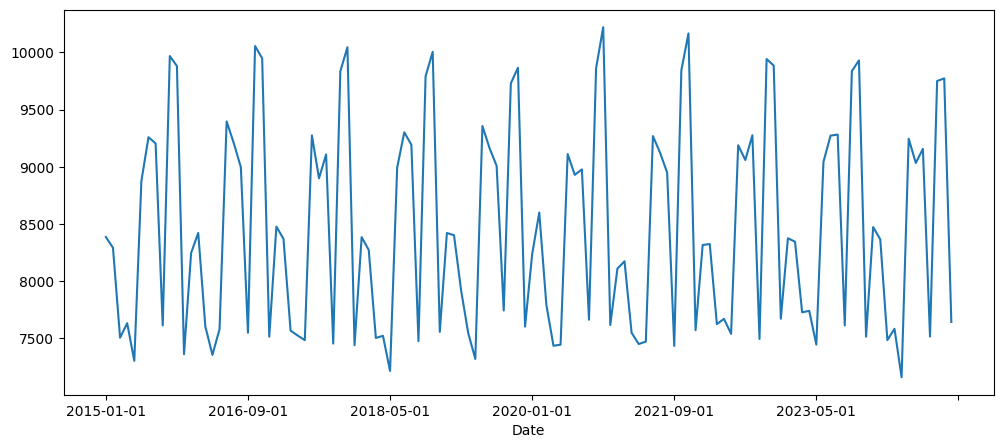

In [3]:
df.groupby('Date')['Tractor_Sales'].sum().plot(figsize=(12, 5))

In [4]:
state_df = df[df['State'] == 'Punjab'].copy()

# Rename for Prophet
state_df.rename(columns={
    'Date': 'ds',
    'Tractor_Sales': 'y'
}, inplace=True)

# Select only needed columns
features = ['CPI', 'Rainfall_mm', 'Cultivable_Land_000_HA', 'Diesel_Price_INR', 'Inventory_Count', 'GDP_INR_Cr']
prophet_df = state_df[['ds', 'y'] + features]


In [5]:
from prophet import Prophet

# Initialize model
model = Prophet(
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.1,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)


# Add extra regressors
for reg in features:
    model.add_regressor(reg)

# Fit model
model.fit(prophet_df)


C:\Users\daksh\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
11:38:03 - cmdstanpy - INFO - Chain [1] start processing
11:38:03 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
state_df['ds'] = pd.to_datetime(state_df['ds'])


In [7]:
last_known = state_df[features].iloc[-1]

# Create future dates
future_dates = pd.date_range(start=state_df['ds'].max() + pd.DateOffset(months=1), periods=12, freq='MS')

# Create future DataFrame with constant values for regressors
future_regressors = pd.DataFrame({
    'ds': future_dates,
    **{f: [last_known[f]] * 12 for f in features}
})

# Combine with existing data
future = pd.concat([state_df[['ds'] + features], future_regressors], ignore_index=True)

In [8]:
forecast = model.predict(future)

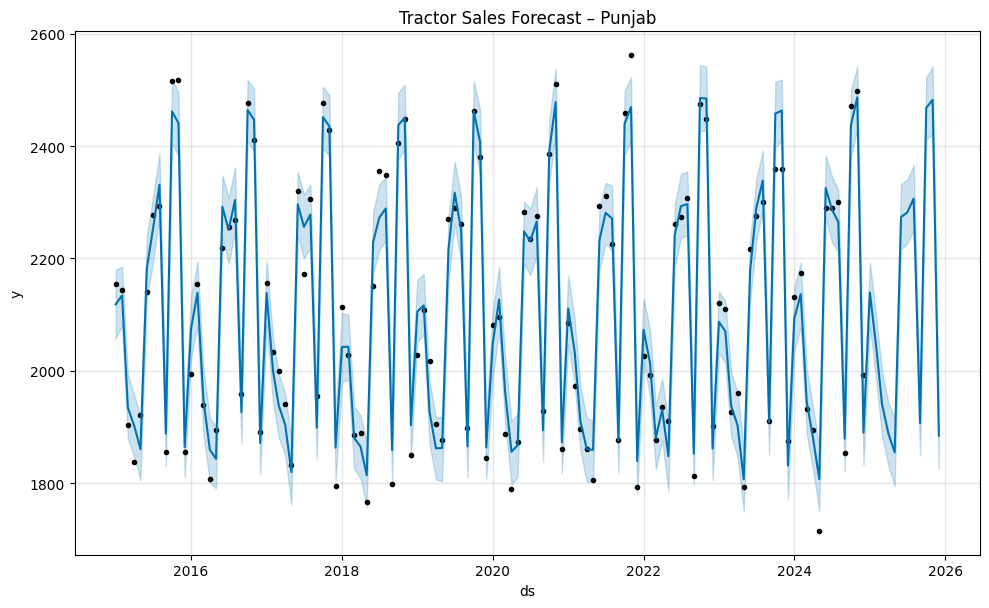

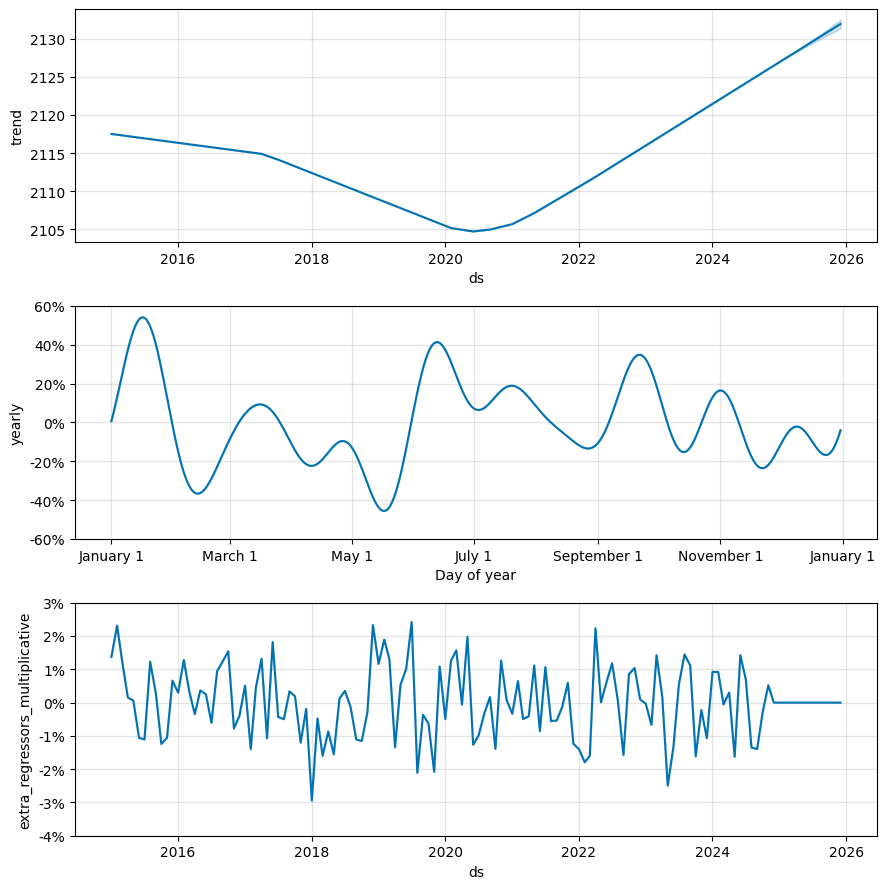

In [9]:
model.plot(forecast)
plt.title('Tractor Sales Forecast – Punjab')
plt.show()

model.plot_components(forecast)
plt.show()


In [16]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
# Filter for a specific state (e.g., Punjab)
state_df = df[df['State'] == 'Punjab'].copy()
state_df.rename(columns={'Date': 'ds', 'Tractor_Sales': 'y'}, inplace=True)
state_df['ds'] = pd.to_datetime(state_df['ds'])

# Select features
features = ['CPI', 'Rainfall_mm', 'Cultivable_Land_000_HA', 'Diesel_Price_INR', 'Inventory_Count', 'GDP_INR_Cr']
prophet_df = state_df[['ds', 'y'] + features].copy()

# Split data
train_df = prophet_df[prophet_df['ds'] < '2023-01-01']
test_df = prophet_df[prophet_df['ds'] >= '2023-01-01']

# Initialize Prophet
model = Prophet(
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.1,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

for f in features:
    model.add_regressor(f)

# Train model
model.fit(train_df)

# Prepare future dataframe (train + test period)
future = pd.concat([train_df[['ds'] + features], test_df[['ds'] + features]], ignore_index=True)

# Predict
forecast = model.predict(future)

# Extract test predictions
forecast_test = forecast[forecast['ds'] >= '2023-01-01']
actual_test = test_df['y'].values
predicted_test = forecast_test['yhat'].values

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(actual_test, predicted_test)
rmse = np.sqrt(mean_squared_error(actual_test, predicted_test))
r2 = r2_score(actual_test, predicted_test)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


11:56:39 - cmdstanpy - INFO - Chain [1] start processing
11:56:40 - cmdstanpy - INFO - Chain [1] done processing


MAE: 58.65
RMSE: 70.44
R² Score: 0.8966


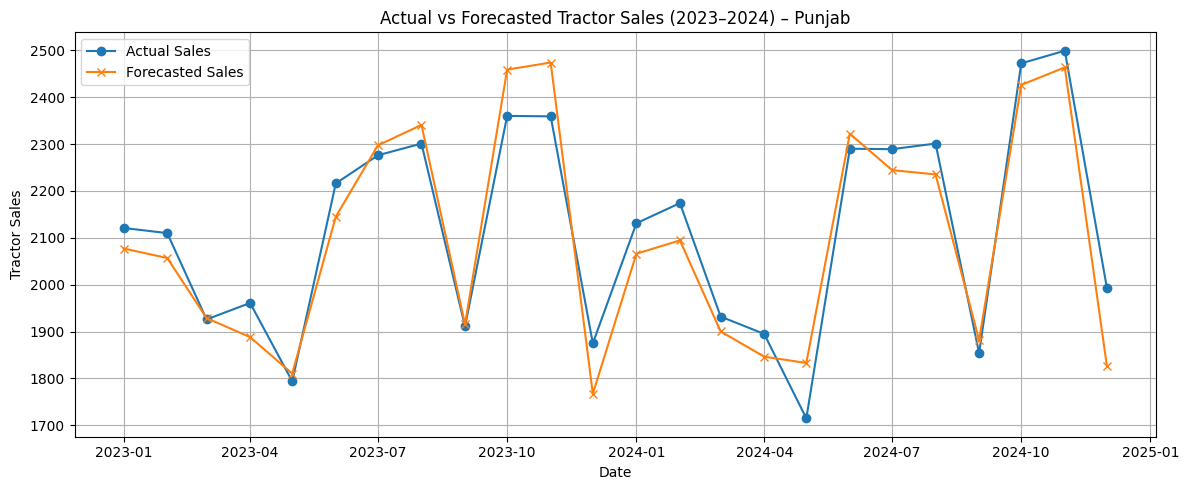

In [17]:
import matplotlib.pyplot as plt

# Create a DataFrame for comparison
compare_df = pd.DataFrame({
    'ds': forecast_test['ds'],
    'Actual': actual_test,
    'Forecasted': predicted_test
})

# Plot
plt.figure(figsize=(12, 5))
plt.plot(compare_df['ds'], compare_df['Actual'], label='Actual Sales', marker='o')
plt.plot(compare_df['ds'], compare_df['Forecasted'], label='Forecasted Sales', marker='x')
plt.title('Actual vs Forecasted Tractor Sales (2023–2024) – Punjab')
plt.xlabel('Date')
plt.ylabel('Tractor Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
